In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import ehtim as eh

from torchvision.transforms import v2
import data.dataset_img as ds
import torchvision
import model_AttnAE2 as mlmodel
import os
from tqdm.auto import tqdm


import glob

from xlogger import *

# use gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'AttnAE_all_v3'
append = True
train_logger = xlogger('models/history/' + model_name + '_train.dat', append=append)
val_logger = xlogger('models/history/' + model_name + '_val.dat', append=append)


/home/lai075/miniconda3/envs/hf/lib/python3.9/site-packages/ehtim/observing/obs_helpers.py:41: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.22.3)
  import scipy.ndimage as nd


Welcome to eht-imaging! v 1.2.8 



In [2]:
# plot all images in the batch
def plot_images(images, save=False, name='images', cmap='viridis', return_axes=False, show=True):
    fig, axes = plt.subplots(2, len(images)//2, figsize=(len(images)//2*0.99, 2))
    fig.subplots_adjust(hspace=0., wspace=0.)
    axes = axes.flatten()
    for ax, img in zip(axes, images):
        ax.imshow(img.permute(1, 2, 0), cmap=cmap)
        ax.axis('off')
    if save:
        direc = 'models/history/'+name+'/'
        os.makedirs(direc, exist_ok=True)
        # check next number
        num = 0
        while glob.glob(f'{direc}{name}_{num}.png'):
            num += 1
        plt.savefig(f'{direc}{name}_{num}.png')
    if show:
        plt.show()
    if return_axes:
        return axes

def log_avgLoss(data, logger):
    # log the avg loss given array of all epochs
    data = np.sum(np.transpose(data), axis=1)/len(data)
    kwargs = {'features_loss': data[0],
              'class_loss': data[1],
              'encoder_corr': data[2],
              'pred_corr': data[3],
              'weighted_loss': data[4]}
    logger.write(kwargs)
    return data
    


def nxcorr(outputs, labels):
    dim = int(outputs.shape[-1])
    outputs = outputs.reshape(-1, dim**2)
    labels = labels.reshape(-1, dim**2)
    
    outputs_norm = (outputs.reshape(-1, dim, dim) - torch.nanmean(outputs, axis=1).reshape(-1, 1, 1)) / torch.std(outputs, axis=1).reshape(-1, 1, 1)
    labels_norm = (labels.reshape(-1, dim, dim) - torch.nanmean(labels, axis=1).reshape(-1, 1, 1)) / torch.std(labels, axis=1).reshape(-1, 1, 1)

    fft_outputs = torch.fft.fftn(outputs_norm, s=[outputs_norm.size(d)*1 for d in [1,2]], dim=[1,2])
    fft_labels = torch.fft.fftn(labels_norm, s=[outputs_norm.size(d)*1 for d in [1,2]], dim=[1,2])

    xcorr = torch.fft.ifftn(fft_outputs * torch.conj(fft_labels), dim=[1,2])

    nxcorr_flat = xcorr.reshape(-1, dim**2)
    idx = torch.argmax(torch.abs(nxcorr_flat), dim=1)

    return idx, torch.abs(nxcorr_flat[torch.arange(nxcorr_flat.shape[0]), idx])/dim**2

def shift_image(im1, im2): # shift single im2 by idx
    idx, _ = nxcorr(im1, im2)
    im2 = torch.roll(im2, shifts=int(idx))
    return im1, im2

def shift_all(truth, imgs):
    shifted_imgs = []
    for img in imgs:
        _, shifted_img = shift_image(truth, img)
        shifted_imgs.append(shifted_img)
    return np.array(shifted_imgs)

def nxcorr_loss(outputs, labels): # assume square images
    _, xcorr = nxcorr(outputs, labels)
    loss_mean = torch.nanmean(1-xcorr)
    return loss_mean

def nxcorr_network_loss(out_img, label_img):
    # normalise outputs and labels
    # outputs = (outputs - torch.mean(outputs, axis=1).reshape(-1, 1)) / torch.std(outputs, axis=1).reshape(-1, 1)
    # labels = (labels - torch.mean(labels, axis=1).reshape(-1, 1)) / torch.std(labels, axis=1).reshape(-1, 1)
    mseloss = nn.MSELoss()
    mse_weight = 1
    mseloss_val = mseloss(out_img, label_img)
    nxcorr_val = nxcorr_loss(out_img, label_img)
    return mse_weight*mseloss_val + nxcorr_val*(1-mse_weight)


mseloss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()
# loss_weights = torch.tensor([1, 0.03, 2.0, 3.0])
loss_weights = torch.tensor([1.0, 0, 2.0, 3.0])

def total_loss(outputs, input_imgs, classes, weights=torch.tensor([1., 1., 1., 1.]), print_loss=False, logger=None):
    features_vae, features_q, features_ci, recon_img, pred_img, pred_class = outputs
    # features_vae = features_vae.view(features_vae.shape[0], -1)
    # features_ci = features_ci.view(features_ci.shape[0], -1)
    
    features_loss = mseloss(features_ci, features_q)

    class_loss = ce_loss(pred_class, classes)
    
    # first channel only
    recon_img = recon_img[:,0]
    pred_img = pred_img[:,0]
    input_imgs = input_imgs[:,0]
    encoder_corr = nxcorr_network_loss(recon_img, input_imgs)
    pred_corr = nxcorr_network_loss(pred_img, input_imgs)


    total = weights[0]*features_loss + weights[1]*class_loss + weights[2]*encoder_corr + weights[3]*pred_corr

    losses_individual = [features_loss.cpu().detach(), 
                         class_loss.cpu().detach(), 
                         encoder_corr.cpu().detach(), 
                         pred_corr.cpu().detach(), 
                         total.cpu().detach()]
    losses_weighted = np.array([weights[i].cpu().detach()*losses_individual[i].cpu().detach() for i in range(len(weights))] + [total.cpu().detach()])
    
    if print_loss:
        print(f'features_loss: {features_loss}, class_loss: {class_loss}, encoder_corr: {encoder_corr}, pred_corr: {pred_corr}')
    if logger:
        kwargs = {'features_loss': features_loss.cpu().detach().numpy(), 
                  'class_loss': class_loss.cpu().detach().numpy(), 
                  'encoder_corr': encoder_corr.cpu().detach().numpy(), 
                  'pred_corr': pred_corr.cpu().detach().numpy(),
                  'weighted_loss': total.cpu().detach().numpy()}
        logger.write(kwargs)
        

    return total, losses_individual, losses_weighted

In [3]:
def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 0.1
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

def square_taper(img, square_size_range=(32, 48), blur_fwhm_range=(5, 10), fixed=False):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    h, w = img.shape[-2:]
    if fixed:
        square_size = square_size_range
        blur_fwhm = blur_fwhm_range
    else:
        square_size = np.random.randint(*square_size_range)
        blur_fwhm = np.random.uniform(*blur_fwhm_range)

    # taper mask
    taper = torch.zeros_like(img)
    taper[:, h//2-square_size//2:h//2+square_size//2, w//2-square_size//2:w//2+square_size//2] = 1
    taper = v2.GaussianBlur(25, sigma=blur_fwhm)(taper)
    
    out = img * taper
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

def radial_taper(img, radii_range=(8, 24), blur_fwhm_range=(5, 10), fixed=False):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    h, w = img.shape[-2:]
    if fixed:
        radius = radii_range
        blur_fwhm = blur_fwhm_range
    else:
        radius = np.random.randint(*radii_range)
        blur_fwhm = np.random.uniform(*blur_fwhm_range)

    # radial taper mask
    taper = torch.zeros_like(img)
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w))
    y = y - h//2
    x = x - w//2
    r = torch.sqrt(x**2 + y**2)
    taper[:, r<radius] = 1
    taper = v2.GaussianBlur(15, sigma=blur_fwhm)(taper)
    
    out = img * taper
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

def fixed_taper(img, size = 16, blur_fwhm = 5):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)

    out = radial_taper(img, size, blur_fwhm, fixed=True)
    

    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out


# random resizing during training
# albumentation
# kornia
# affine transformation (zoom in zoom out, rotate, shear) elastic deformation/warping

train_transforms = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomAffine(degrees=(-90, 90), scale=(0.8, 1.), shear=(-5, 5), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    v2.CenterCrop(64),
])

val_transforms = v2.Compose([
    v2.ToTensor(),
    v2.CenterCrop(64),
])

val_transforms_rotate = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomAffine(degrees=(-90, 90), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    v2.CenterCrop(64),
])


val_transforms_taper = v2.Compose([
    v2.ToTensor(),
    fixed_taper,
    v2.CenterCrop(64),
])


cifar_train_transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize(64),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomAffine(degrees=(-90, 90), scale=(0.8, 1.), shear=(-5, 5), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    radial_taper,
    v2.CenterCrop(64),
])

cifar_val_transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize(64),
    fixed_taper,
    v2.CenterCrop(64),
])


test_transforms = v2.Compose([
    v2.ToTensor(),
    # v2.Resize(38),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomAffine(degrees=(-90, 90), scale=(0.4, 0.7), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    # v2.RandomAffine(degrees=(0, 0), scale=(0.62, 0.62), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    # radial_taper,
    v2.CenterCrop(64),
])

test_transforms_noRotate = v2.Compose([
    v2.ToTensor(),
    # v2.Resize(38),
    v2.RandomAffine(degrees=(0, 0), scale=(0.4, 0.7), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    # v2.RandomAffine(degrees=(0, 0), scale=(0.62, 0.62), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    # radial_taper,
    v2.CenterCrop(64),
])


test_transforms_noise = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomAffine(degrees=(-90, 90), scale=(0.4, 0.7), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    v2.CenterCrop(64),
    gauss_noise_tensor,
])

fidelity_test = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomAffine(degrees=(-90, 90), scale=(0.7, 1.3), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    v2.CenterCrop(64),
])

fidelity_test_shear = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomAffine(degrees=(-90, 90), scale=(0.7, 1.3), shear=(-30, 30), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    v2.CenterCrop(64),
])


transforms_dict = {
    'train': train_transforms,
    'val': val_transforms,
    'cifar_train': cifar_train_transforms,
    'cifar_val': cifar_val_transforms,
    'test': test_transforms,
}


In [4]:
load = True

# initialise weights
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

if load:
    model = torch.load('models/'+model_name+'.pt').to(device)
else: 
    model = mlmodel.Vae_FD(k_classes=8).to(device)
    model.apply(weights_init)

if False: # WARNING: Replaces all parameters but the transformer!
    # load encoder, decoder, classifier from pre-trained model
    pretrained = torch.load('models/AttnAE_all.pt').named_parameters()
    dict_params = dict(pretrained)
    for name, param in model.named_parameters():
        if 'ci_xtrans' in name:
            continue
        if name in dict_params:
            param.data = dict_params[name].data

ehtim=True
tint_sec = 5   
tadv_sec = 600
tstart_hr = 0
tstop_hr = 24
# psize = 7.757018897750619e-12 * 2
psize = 1.7044214966184275e-11
bw_hz = [230E9]#, 345E9]
reorder = True

batch_size = 32

data_dir = 'data/datasets/v3/'
mnames = ['gauss', 'disk', 'ellipse', 'ring', 'mring', 'disk2', 'gauss2', 'cifar10-128']

val_data = ds.ImgDataset(['data/datasets/val/val_mring.npy'], transform=val_transforms, ehtim=ehtim,
                            tint_sec=tint_sec, tadv_sec=tadv_sec, tstart_hr=tstart_hr, tstop_hr=tstop_hr, bw_hz=bw_hz, psize=psize,
                            reorder=reorder)

val = DataLoader(val_data, batch_size=batch_size, shuffle=True)

dataiter = iter(val)
static_val = next(dataiter)

# plot_images(static_val[0])



[252]
Loading text image:  ./data/template_sgra.txt
['mring']


In [ ]:
# test the model
test = DataLoader(val_data, batch_size=32, shuffle=True)
for i, data in enumerate(test, 0):
    img, ci, cls = data
    ci = torch.tensor(val.dataset.closure.FTCI(img).reshape(batch_size, -1), dtype=torch.float32)
    img, ci, cls = img.to(device), ci.to(device), cls.to(device)
    features_vae, features_q, features_ci, recon_img, pred_img, pred_class = model(img, ci)
    plot_images(img.cpu().detach())
    plot_images(recon_img.cpu().detach()) 
    plot_images(pred_img.cpu().detach()) 
    break



Loading fits image:  Images/ring.fits
Classes: [[0.00945419 0.849562   0.00400767 0.00604403 0.06592306 0.05017074
  0.01158865 0.00324963]]
disk


Text(0.5, 1.0, 'CI Residual')

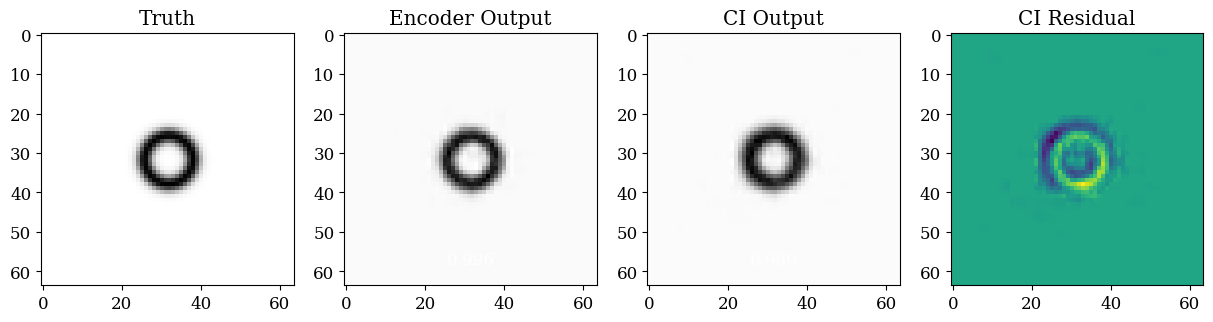

In [16]:
# testing with image
import seaborn as sns

cmap = 'Greys'

def gauss_noise(img, sigma):
    out = img + sigma * torch.randn_like(img).numpy()
    return out

def N_noisy_reconstructions(N, img, stds, add_th_noise=False):
    outs = []
    test_ims = []
    for std in stds:
        batch_imgs = img.repeat(N, 1, 1)
        test_im = gauss_noise(batch_imgs, std).reshape(N, imgdim, imgdim)
        test_ims.append(test_im)

    test_ims = np.array(test_ims).reshape(-1, imgdim, imgdim)
    test_ims = torch.tensor(test_ims, dtype=torch.float32).to(device)
    test_invs = val.dataset.closure.FTCI(test_ims, add_th_noise=add_th_noise).reshape(test_ims.shape[0], -1)
    test_invs = torch.tensor(test_invs, dtype=torch.float32).reshape(test_ims.shape[0], -1)
    test_invs = test_invs.to(device)

    for inv in test_invs:
        _, outputs, _ = model.predict_with_attn(inv.reshape(1, -1))
        outputs = outputs.cpu().detach().numpy().reshape(imgdim,imgdim)
        outputs = (outputs - np.min(outputs))/(np.max(outputs) - np.min(outputs))
        outs.append(outputs)
    
    return np.array(outs)

def N_transforms(N, img, transform, add_th_noise=False):
    # fidelity distribution
    fides = []
    outs = []
    test_im = img.repeat(N, 1, 1)
    
    test_im = torch.tensor(np.array([transform(i.reshape(1, imgdim, imgdim)) for i in test_im]), dtype=torch.float32).to(device)
    test_inv = val.dataset.closure.FTCI(test_im, add_th_noise=add_th_noise).reshape(N, -1)
    test_inv = torch.tensor(test_inv, dtype=torch.float32).to(device)

    for img, inv in zip(test_im, test_inv):
        _, outputs, _ = model.predict_with_attn(inv)
        outputs = outputs.cpu().detach().numpy().reshape(imgdim,imgdim)
        outputs = (outputs - np.min(outputs))/(np.max(outputs) - np.min(outputs))
        fide = nxcorr(torch.Tensor(outputs).to(device), torch.Tensor(img))[1].cpu().detach().numpy()[0]
        fides.append(fide)
        outs.append(outputs)

    return test_im, test_inv, outs, fides

def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def crps_score(truth, imgs):
    imgs = np.array(imgs)
    imgs = imgs.reshape(imgs.shape[0], -1)
    truth = truth.reshape(-1)
    crps_scores = []
    for i in range(imgs.shape[1]):
        out_pix = imgs[:, i]
        mean_out_pix = np.mean(out_pix)+0.1
        truth_pix = truth[i]
        x, y = ecdf(out_pix)
        step_fc = np.heaviside(x-truth_pix, 0.5)
        crps = np.trapz((y-step_fc)**2, x)
        crps_scores.append(crps)

    crps_scores = np.array(crps_scores).reshape(64, 64)
    tot_crps = np.sum(crps_scores)/(truth.shape[0])
    return tot_crps, crps_scores    

imgdim = 64

model = torch.load('models/'+model_name+'.pt')

load_fits = 'Images/ring.fits'
img = eh.image.load_fits(load_fits)
name = load_fits.split('/')[-1].split('.')[0]

# im = img.regrid_image(img.fovx(), imgdim).imarr()
im = img.imarr()

im = im/np.max(im) # normalise the intensity
# im = test_transforms(im)
# im = test_transforms_noRotate(im)
# im = val_transforms(im)
# im = fidelity_test_shear(im)
im = torch.tensor(im).to(torch.float32).reshape(1, imgdim, imgdim)
# im = gauss_noise(im, 0.1).reshape(1, imgdim, imgdim)
in_im = np.copy(im)

img._imdict['I'] = np.swapaxes(in_im, 1, 2) # swap img axis for obs
img.mjd = 57848
img.ra = 187.7059167/360*24
img.dec = 12.3911222
img.psize = 1.7044214966184275e-11 

integrated_flux = 100

img._imdict['I'] = img._imdict['I']/img.total_flux()*integrated_flux

obs = img.observe(eh.array.load_txt('data/EHT2017.txt'), tint_sec, tadv_sec, tstart_hr, tstop_hr, 8e9, mjd = img.mjd, ttype='DFT',  
            sgrscat=False, ampcal=True, phasecal=True, noise=True, add_th_noise=True, th_noise_factor=1,
            gainp=0.1, reorder=reorder, verbose=False)

img._imdict['I'] = np.swapaxes(in_im, 1, 2) # swap back after obs


if True:
    invs = torch.tensor(val.dataset.closure.FTCI(im, add_th_noise=False, method=1, th_noise_factor=1).reshape(1, -1), dtype=torch.float32).to(device)
else:
    invs = torch.tensor(obs.ClosureInvariants().reshape(1, -1), dtype=torch.float32).to(device) # invs from obs



out_features, outputs, attns = model.predict_with_attn(invs)
outputs = outputs.cpu().detach().numpy().reshape(imgdim,imgdim)
outputs = (outputs - np.min(outputs))/(np.max(outputs) - np.min(outputs))

im, outputs = im.reshape(imgdim, imgdim), outputs.reshape(imgdim, imgdim)#.numpy()


encoder_latent, _, encoder_out = model.encoder_to_img(torch.Tensor(im).view(1,1,imgdim, imgdim).to(device))
encoder_out = encoder_out.cpu().detach().numpy().reshape(imgdim, imgdim)

# predict class
cls_pred = model.predict_class(invs).cpu().detach().numpy()
print('Classes:', cls_pred)
cls_pred = mnames[np.argmax(cls_pred)]
print(cls_pred)


fig, ax = plt.subplots(1, 4, figsize=(15,5))
ax[0].imshow(im, cmap=cmap)
ax[0].set_title('Truth')

ax[1].imshow(encoder_out, cmap=cmap)
ax[1].set_title('Encoder Output')
idx, xcorr = nxcorr(torch.tensor(encoder_out), torch.tensor(in_im))
xcorr = xcorr.cpu().detach().numpy()[0]
ax[1].text(0.5, 0.1, f'{xcorr:.3f}', ha='center', va='center', transform=ax[1].transAxes, color='white')

ax[2].imshow(outputs, cmap=cmap)
ax[2].set_title('CI Output')
idx, xcorr = nxcorr(torch.tensor(outputs), torch.tensor(in_im))
xcorr = xcorr.cpu().detach().numpy()[0]
ax[2].text(0.5, 0.1, f'{xcorr:.3f}', ha='center', va='center', transform=ax[2].transAxes, color='white')


ax[3].imshow(im-outputs)
ax[3].set_title('CI Residual')



[872022.45392512 868053.57499534 862423.2476762  855142.24837371
 846224.51287015 846224.51287015]
[-1766362.51655259 -1758192.75010169 -1750068.0525281  -1742003.97444557
 -1734015.95044218 -1734015.95044218]


Text(0, 0.5, 'v')

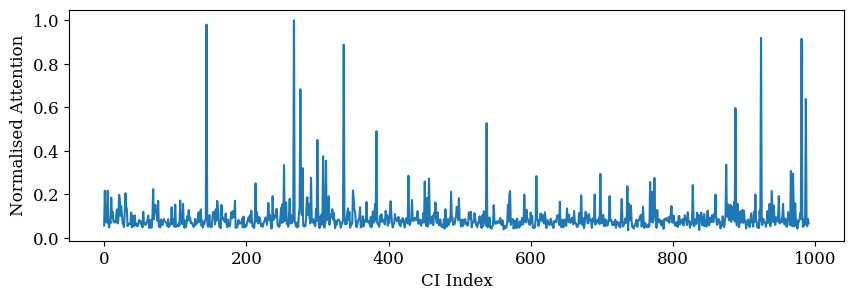

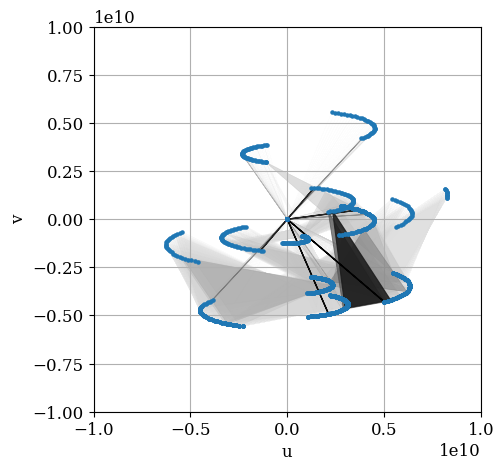

In [17]:
# Attention Maps

from matplotlib.patches import Polygon


# average over head and layers and patch (collapse)
avg_attns = attns.mean(axis=(0,1,2,3)).cpu().detach().numpy()[:-1]

# normalise
avg_attns = avg_attns/np.max(avg_attns)

ci, uv_orig, _ = val.dataset.closure.FTCI(np.array([in_im, in_im]), return_uv=True)
uv = uv_orig[0]
uv = np.repeat(uv, 2, axis=2)
ci = np.array(ci.reshape(-1))


fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(avg_attns)

    
ax.set_ylabel('Normalised Attention')
ax.set_xlabel('CI Index')


fig, ax = plt.subplots(figsize=(5,5))

# plot triangles with uv
for i in range(uv.shape[-1]):
    attn_val = avg_attns[i]
    ci_val = ci[i]
    # map attn_val to colormap
    cmap = plt.get_cmap('binary')
    attn_col = cmap(attn_val)

    if attn_val > 0.6:
        # print(uv[:, :, i].T)
        pass

    s = Polygon(np.array(uv[:, :, i].T), edgecolor=attn_col, facecolor=attn_col, alpha=attn_val, linewidth=attn_val, zorder=1+attn_val)
    ax.add_patch(s)


# plot all uv points
uv_plot = uv_orig.reshape(2, -1)
print(uv_plot[0, :6])
print(uv_plot[1, :6])
ax.scatter(uv_plot[0, :], uv_plot[1, :], color='C0', zorder=5, s=5)

ax.set_xlim(-1e10, 1e10)
ax.set_ylim(-1e10, 1e10)
ax.grid()
ax.set_xlabel('u')
ax.set_ylabel('v')


Loading fits image:  Images/ring.fits
Loading fits image:  Images/sgra.fits


Text(0, 0.5, 'v')

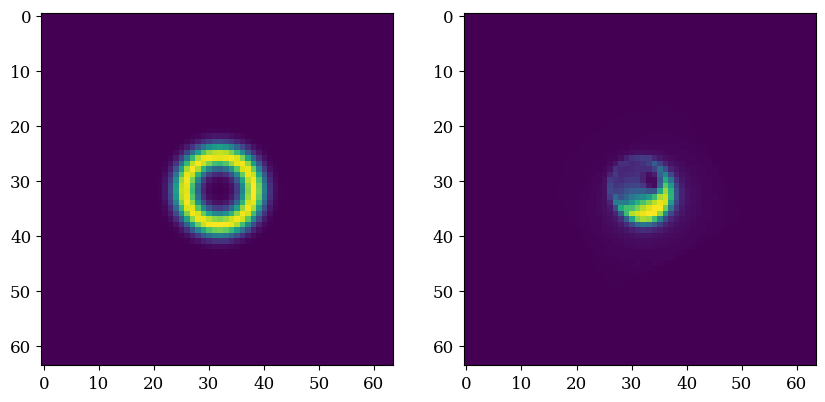

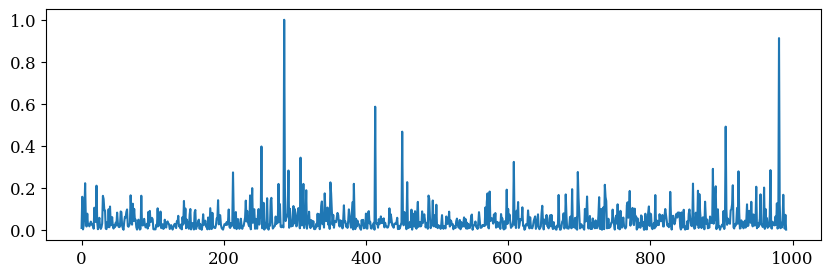

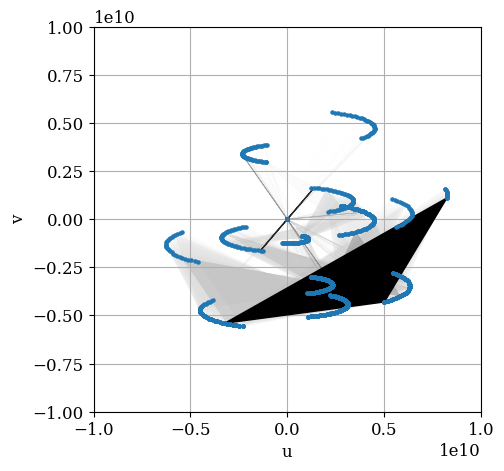

In [23]:
# Difference between two attention maps

img1 = eh.image.load_fits('Images/ring.fits')
img2 = eh.image.load_fits('Images/sgra.fits')

fig, ax = plt.subplots(1,2, figsize=(10,5))
imgs = [img1, img2]
transforms = [val_transforms, test_transforms]
attns_array = []

for i, img in enumerate(imgs):
    im = img.imarr()
    im = im/np.max(im) # normalise the intensity

    im = transforms[i](im)
    im = im.to(torch.float32)
    ax[i].imshow(im[0])

    invs = val.dataset.closure.FTCI(im).reshape(1, -1)

    invs = torch.tensor(invs, dtype=torch.float32).reshape(1, -1)
    invs = invs.to(device)
    out_features, outputs, attns = model.predict_with_attn(invs)
    outputs = outputs.cpu().detach().numpy().reshape(imgdim,imgdim)
    avg_attns = attns.mean(axis=(0,1,2,3)).cpu().detach().numpy()[:-1]
    attns_array.append(avg_attns)



diff = np.abs(attns_array[0] - attns_array[1])
# diff = attns_array[0]/attns_array[1]


# normalise
diff = (diff - np.min(diff))/(np.max(diff) - np.min(diff))

ci, uv_orig, _ = val.dataset.closure.FTCI(in_im, return_uv=True)
uv = uv_orig[0]
uv = np.repeat(uv, 2, axis=2)
ci = np.array(ci.reshape(-1))

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(diff)

fig, ax = plt.subplots(figsize=(5,5))


for i in range(uv.shape[-1]):
    attn_val = diff[i]
    # map attn_val to colormap
    cmap = plt.get_cmap('binary')
    attn_col = cmap(attn_val)

    s = Polygon(np.array(uv[:, :, i].T), edgecolor=attn_col, facecolor=attn_col, alpha=attn_val, linewidth=attn_val, zorder=1+attn_val)
    ax.add_patch(s)

uv_plot = uv_orig.reshape(2, -1)
ax.scatter(uv_plot[0, :], uv_plot[1, :], color='C0', zorder=5, s=5)

ax.set_xlim(-1e10, 1e10)
ax.set_ylim(-1e10, 1e10)
ax.grid()
ax.set_xlabel('u')
ax.set_ylabel('v')
